<a href="https://colab.research.google.com/github/luanavsr/VaR_Portfolio/blob/main/Aplica%C3%A7%C3%A3o_GARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importando os pacotes
!pip install arch
import arch
from arch import arch_model

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
import seaborn as sns
import statsmodels


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 6.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


[*********************100%%**********************]  4 of 4 completed


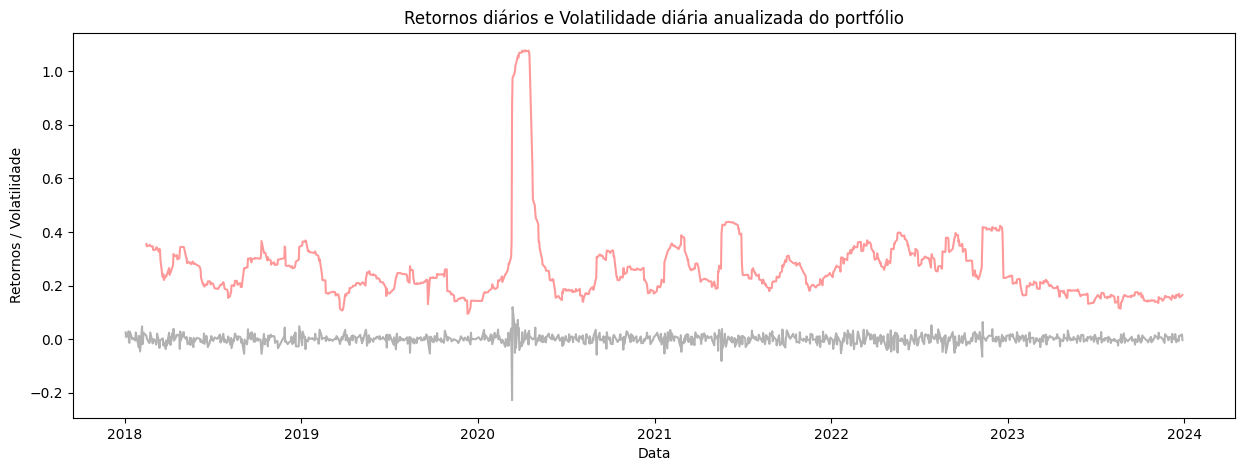

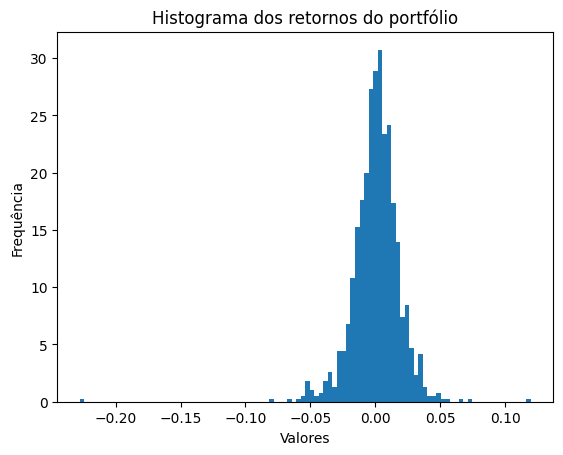

In [ ]:
# Baixando os dados
start_date = '2017-12-31'
end_date = '2023-12-29'

# Preço de fechamento ajustado do Ibovespa, SP500, ETH e Nasdaq
stocks_list = ['^BVSP', '^GSPC','ETH-USD','^IXIC']
data_df = yf.download(stocks_list, start=start_date, end=end_date)['Adj Close']

# Calculando os retornos em log, para retorno simples use: data_df.pct_change().dropna()
returns_df = data_df.apply(np.log).diff().dropna()

# Definindo o peso de cada ativo no portfólio (equal weights)
weights = [1 / returns_df.columns.size] * returns_df.columns.size

# Calculando o retorno diário do portfólio e transformando em dataframe
port_returns = returns_df.mul(weights, axis=1).sum(axis=1)
port_returns = pd.DataFrame(port_returns, columns = ['Port Return'])

# Calculando a volatilidade anualizada do portfólio em uma janela móvel de 21 dias
daily_vol = port_returns.rolling(window=21).std() * np.sqrt(252)

# plotando os retornos diários do portfólio
plt.figure(figsize=(15,5))
plt.plot(port_returns, color='gray', alpha=0.6, label='Retornos diários do portfólio')
plt.plot(daily_vol, color='red', alpha=0.4, label='Volatilidade diária do portfólio')
plt.xlabel('Data')
plt.ylabel('Retornos / Volatilidade')
plt.title('Retornos diários e Volatilidade diária anualizada do portfólio')
plt.show()

# plotando a distribuição dos retornos
plt.hist(port_returns, bins=100, density='True')
plt.xlabel('Valores')
plt.ylabel('Frequência')
plt.title('Histograma dos retornos do portfólio')
plt.show()


In [ ]:
# Tamanho da amostra de treinamento (70% das observações)
n_training = 0.7

# Separando a amostra em dados de treinamento e dados de teste
data_training, data_test = port_returns [:int(len(port_returns )*n_training)], port_returns [int(len(port_returns )*n_training):]

In [ ]:
# Estimando um modelo GARCH (1,1) com média constante e distribuição skewt
g_model = arch.arch_model(data_training, p=1, q=1, mean='constant', vol = 'GARCH', dist='normal').fit(disp='off')
g_model.summary() #verificar se o modelo é estatísticamente significante

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000127. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:            Port Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2519.25
Distribution:                  Normal   AIC:                          -5030.51
Method:            Maximum Likelihood   BIC:                          -5012.11
                                        No. Observations:                  735
Date:                Tue, Jan 30 2024   Df Residuals:                      734
Time:                        10:43:55   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         5.9020e-04  5.754e-05     10.257  1.097e-24 [4.774e-04,7.030e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.5392e-06  1.338e-10  1.898e+04      0.000 [2.539e-06,2.539e-06]
alpha[1]       0.2000  5.627e-02      3.554  3.788e-04   [8.972e-02,  0.310]
beta[1]        0.7800  4.084e-02     19.098  2.606e-81     [  0.700,  0.860]
============================================================================

Covariance estimator: robust
"""

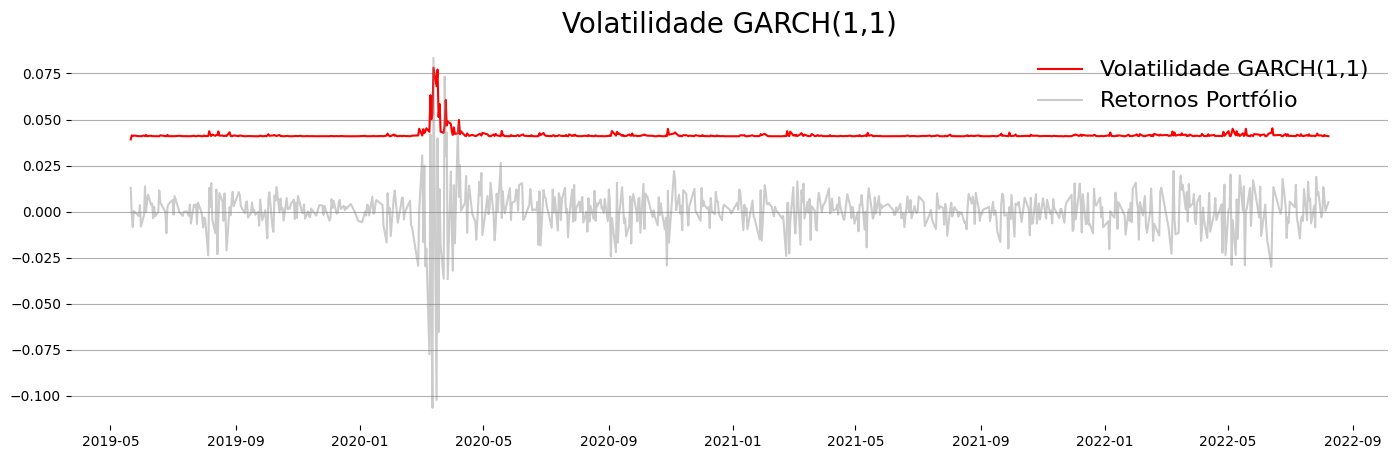

In [ ]:
# Plot model fitting results
plt.figure(figsize=(17,5))
plt.plot(g_model.conditional_volatility, color = 'red', label = 'Volatilidade GARCH(1,1)')
plt.plot(data_training, color = 'grey',
         label = 'Retornos Portfólio', alpha = 0.4)
plt.legend(loc = 'best', frameon=False, fontsize=16)
plt.title("Volatilidade GARCH(1,1)", fontsize=20)
plt.box(False)
plt.grid(True,axis="y")
plt.show()